In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gzip

from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras.layers import Conv2D, Input, Dense, Flatten,Dropout, merge, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras import regularizers
from keras import backend as k
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

### Loading the data

In [6]:
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
(train_data,train_labels),(test_data,test_labels)=fashion_mnist.load_data()

In [7]:
train_labels[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

### Data Exploration

In [87]:
# printing the dimension of images in the training set
print("Training set (images) shape: {shape}", format(train_data.shape))

# printing the dimension of images in the test set
print("Test set (image) shape: {shape}", format(test_data.shape))
test_data.dtype

Training set (images) shape: {shape} (60000, 28, 28, 1)
Test set (image) shape: {shape} (10000, 28, 28, 1)


dtype('float64')

In [9]:
# creating a dictionary of class names with their corresponding class labels:
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J' 
}

Text(0.5, 1.0, '(Label: E)')

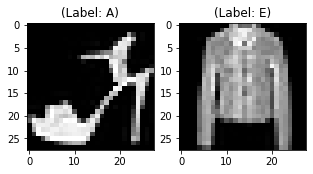

In [10]:
plt.figure(figsize=[5,5])

# sample image from the training data
plt.subplot(121)
curr_img = np.reshape(train_data[9], (28,28))
curr_label = train_labels[10]
plt.imshow(curr_img, cmap = 'gray')
plt.title("(Label: " + str(label_dict[curr_label]) + ")")

# sample image from the testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_label = test_labels[10]
plt.imshow(curr_img, cmap= 'gray')
plt.title("(Label: " + str(label_dict[curr_label])+ ")")

### Data Preprocessing

In [11]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (60000, 28, 28, 1)
Test data shape (10000, 28, 28, 1)


In [12]:
#datatype of the numpy arrays
train_data.dtype, test_data.dtype

(dtype('uint8'), dtype('uint8'))

In [13]:
# rescaling the pixel values to 0-1 scale by rescaling with maximum pixel value of the training and testing data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [14]:
# verify the maximum value of the training and the testing data
np.max(train_data), np.max(test_data)

(1.0, 1.0)

### Splitting the data into train and validation sets

In [15]:
# We will now split the data into 80% training and 20% validation. This will help us to reduce the chances of overfitting
# as you would be validating the model on the data it has not seen in the training.
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data, test_size = 0.2, random_state = 12345)

In [16]:
X_train.shape, X_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

In [17]:
# Initialising the variables 
batch_size = 128
epochs = 100
channel = 1
x, y = 28, 28
input_image = Input(shape = (x, y, channel))
num_classes = 10

# Building Encoder

In [18]:
# Building an encoder
def encoder(input_image):
    # input shape - 28 * 28 * 1
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (input_image) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)  
    
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2)) (conv2) 
    
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv3)
    conv3 = BatchNormalization()(conv3)
    
    conv4 = Conv2D(256,(3,3), activation = 'relu', padding = 'same') (conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same') (conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

# Building Decoder

In [19]:
# Building a decoder
def decoder(conv4):
    conv5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv4) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    conv6 = Conv2D(64, (3,3), activation= 'relu', padding ='same') (conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3,3), activation= 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2)) (conv6) 
    
    conv7 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (up1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3,3), activation ='relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) 
    
    decoded = Conv2D(1,(3, 3),  activation = 'sigmoid', padding ='same') (up2) 
    return decoded

# Compiling the Autoencoder

In [20]:

autoencoder = Model(input_image, decoder(encoder(input_image)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [21]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

### Training the model 

In [22]:
csv_logger = CSVLogger('autoencoder_log.csv', append = True, separator = ';')
history = autoencoder.fit(X_train, y_train, batch_size = batch_size, epochs= epochs,
                                   verbose =1, validation_data = (X_val, y_val), callbacks = [csv_logger])

Epoch 1/100
375/375 [==============================] - 436s 1s/step - loss: 0.0262 - val_loss: 0.0242
Epoch 2/100
375/375 [==============================] - 431s 1s/step - loss: 0.0116 - val_loss: 0.0812
Epoch 3/100
375/375 [==============================] - 432s 1s/step - loss: 0.0089 - val_loss: 0.0100
Epoch 4/100
375/375 [==============================] - 435s 1s/step - loss: 0.0074 - val_loss: 0.0074
Epoch 5/100
375/375 [==============================] - 436s 1s/step - loss: 0.0065 - val_loss: 0.0056
Epoch 6/100
375/375 [==============================] - 434s 1s/step - loss: 0.0061 - val_loss: 0.0103
Epoch 7/100
375/375 [==============================] - 434s 1s/step - loss: 0.0058 - val_loss: 0.0055
Epoch 8/100
375/375 [==============================] - 437s 1s/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/100
375/375 [==============================] - 435s 1s/step - loss: 0.0048 - val_loss: 0.0054
Epoch 10/100
375/375 [==============================] - 433s 1s/step - loss: 0.004

In [23]:
# saving the model
autoencoder_json = autoencoder.to_json()
with open('autoencoder_json','w') as json_file:
    json_file.write(autoencoder_json)

dict_keys(['loss', 'val_loss'])


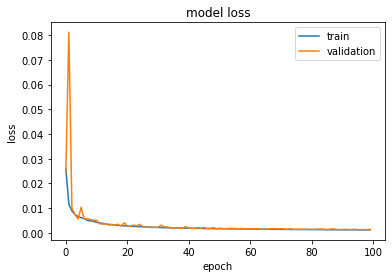

In [24]:
# Now we can plot the loss curves

print(history.history.keys())


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [25]:
# We will need the encoder weights of the autoencoder for classification task. We will now save the 
# full autoencoder weights and then we will learn to extract the encoder weights.
autoencoder.save_weights('autoencoder_weights.h5')

### Classifying the fashion MNIST images

In [26]:
X_train_one_hot = to_categorical(train_labels)
X_test_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('One-hot label:', X_train_one_hot[0])

Original label: 9
One-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [27]:
# Splitting the data again into train and test for classification purpose using the one hot labels this time
X_trainc, X_valc, y_trainc, y_valc = train_test_split(train_data, X_train_one_hot, test_size = 0.2, random_state = 12345)

In [28]:
# checking the shape
X_trainc.shape, X_valc.shape, y_trainc.shape, y_valc.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [29]:
# Now we will be using building the classification model using the encoder part (define encoder) of the autoencoder
# defining the fully connected layer for the encoder part
def fc(enco):
    flat = Flatten() (enco)
    fc1 = Dense(128, activation = 'relu') (flat)
    fc2 = Dense(num_classes, activation = 'softmax') (fc1)
    return fc2

In [30]:
encode = encoder(input_image)
full_model = Model(input_image, fc(encode))

In [31]:
for l1, l2 in zip(full_model.layers[:19], autoencoder.layers[:19]):
    l1.set_weights(l2.get_weights())

In [32]:
# Since, we are using the encoder part of the autoencoder for classification purpose, we should make sure that
# the weights of the encoder part of the autoencoder are are similar to the weights you loaded to the 
# encoder function of the classification model. If they are not similar, there is no pointin using the autoencoder classification
# strategy.

# First layer weight of autoencoder
autoencoder.get_weights()[0][1]

array([[[ 0.07375596,  0.2651533 ,  0.56218255,  0.20129573,
         -0.11216035, -0.20904149,  0.02443863,  0.44175398,
          0.11604084,  0.23045723,  0.12635857,  0.42941278,
          0.2828353 ,  0.41915488,  0.30472046,  0.0243328 ,
         -0.49696025, -0.04381758,  0.11629681,  0.04742721,
          0.22531399, -0.01945964, -0.51593906,  0.05804438,
          0.20296398,  0.09543183, -0.34707573,  0.25795576,
         -0.0502386 , -0.03639699, -0.09470027, -0.11435283]],

       [[ 0.05823249,  0.38423905,  0.37055585,  0.4159702 ,
          0.34714267, -0.26621285, -0.37522796,  0.39226806,
          0.22058722, -0.08736181,  0.24374838,  0.13325825,
         -0.6357485 ,  0.08793259, -0.32201198, -0.51618934,
         -0.19949742, -0.13073376, -0.13892627,  0.13014618,
          0.28517693, -0.13370119, -0.5826272 ,  0.11547647,
         -0.5893666 ,  0.3162103 ,  0.17543757, -0.48331398,
         -0.38856763,  0.25865647,  0.54973954,  0.15233494]],

       [[-0.116883

In [33]:
full_model.get_weights()[0][1]

array([[[ 0.07375596,  0.2651533 ,  0.56218255,  0.20129573,
         -0.11216035, -0.20904149,  0.02443863,  0.44175398,
          0.11604084,  0.23045723,  0.12635857,  0.42941278,
          0.2828353 ,  0.41915488,  0.30472046,  0.0243328 ,
         -0.49696025, -0.04381758,  0.11629681,  0.04742721,
          0.22531399, -0.01945964, -0.51593906,  0.05804438,
          0.20296398,  0.09543183, -0.34707573,  0.25795576,
         -0.0502386 , -0.03639699, -0.09470027, -0.11435283]],

       [[ 0.05823249,  0.38423905,  0.37055585,  0.4159702 ,
          0.34714267, -0.26621285, -0.37522796,  0.39226806,
          0.22058722, -0.08736181,  0.24374838,  0.13325825,
         -0.6357485 ,  0.08793259, -0.32201198, -0.51618934,
         -0.19949742, -0.13073376, -0.13892627,  0.13014618,
          0.28517693, -0.13370119, -0.5826272 ,  0.11547647,
         -0.5893666 ,  0.3162103 ,  0.17543757, -0.48331398,
         -0.38856763,  0.25865647,  0.54973954,  0.15233494]],

       [[-0.116883

In [34]:
# Since the encoder part is already trained, we do not need to train it again. So, we will make those 
# 19 layers of the model as trainable false. We will only train the fully connected layer part
for layer in full_model.layers[:19]:
    layer.trainable = False

In [35]:
# Now, we will compile the model
full_model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [36]:
# summary of the model
full_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0   

### Training the classification model

In [37]:
# Training the model for 100 epochs using the keras fit function and visualizing the accuracy and loss curves

history_classification = full_model.fit(X_train, y_trainc, batch_size = 64, epochs= 100,
                                   verbose =1, validation_data = (X_valc, y_valc))

Epoch 1/100
750/750 [==============================] - 74s 97ms/step - loss: 0.3781 - accuracy: 0.8727 - val_loss: 0.2692 - val_accuracy: 0.9018
Epoch 2/100
750/750 [==============================] - 74s 99ms/step - loss: 0.2327 - accuracy: 0.9146 - val_loss: 0.2461 - val_accuracy: 0.9132
Epoch 3/100
750/750 [==============================] - 84s 113ms/step - loss: 0.1930 - accuracy: 0.9288 - val_loss: 0.2628 - val_accuracy: 0.9140
Epoch 4/100
750/750 [==============================] - 85s 113ms/step - loss: 0.1614 - accuracy: 0.9402 - val_loss: 0.2684 - val_accuracy: 0.9181
Epoch 5/100
750/750 [==============================] - 80s 107ms/step - loss: 0.1474 - accuracy: 0.9455 - val_loss: 0.2899 - val_accuracy: 0.9098
Epoch 6/100
750/750 [==============================] - 77s 103ms/step - loss: 0.1282 - accuracy: 0.9513 - val_loss: 0.2985 - val_accuracy: 0.9105
Epoch 7/100
750/750 [==============================] - 78s 105ms/step - loss: 0.1140 - accuracy: 0.9577 - val_loss: 0.2973 - v

Epoch 57/100
750/750 [==============================] - 77s 102ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.9159 - val_accuracy: 0.9122
Epoch 58/100
750/750 [==============================] - 78s 103ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.8967 - val_accuracy: 0.9148
Epoch 59/100
750/750 [==============================] - 77s 103ms/step - loss: 0.0159 - accuracy: 0.9952 - val_loss: 0.9860 - val_accuracy: 0.9099
Epoch 60/100
750/750 [==============================] - 77s 103ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.9393 - val_accuracy: 0.9183
Epoch 61/100
750/750 [==============================] - 77s 103ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.9749 - val_accuracy: 0.9161
Epoch 62/100
750/750 [==============================] - 76s 102ms/step - loss: 0.0211 - accuracy: 0.9941 - val_loss: 0.9607 - val_accuracy: 0.9180
Epoch 63/100
750/750 [==============================] - 77s 102ms/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 0

In [38]:
# Saving the classification model's weights
full_model.save_weights('full_model_weights.h5')

### Retraining the full model

In [39]:
# Now we will retrain the full model along with the other 19 layers
for layer in full_model.layers[:19]:
    layer.trainable = True

In [40]:
# Now, we will compile the model
full_model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [41]:
history_classification = full_model.fit(X_train, y_trainc, batch_size = 64, epochs= 100,
                                   verbose =1, validation_data = (X_valc, y_valc))

Epoch 1/100
750/750 [==============================] - 292s 385ms/step - loss: 0.3045 - accuracy: 0.9405 - val_loss: 0.7607 - val_accuracy: 0.8950
Epoch 2/100
750/750 [==============================] - 289s 385ms/step - loss: 0.1679 - accuracy: 0.9545 - val_loss: 0.5775 - val_accuracy: 0.9098
Epoch 3/100
750/750 [==============================] - 316s 421ms/step - loss: 0.1075 - accuracy: 0.9681 - val_loss: 0.6952 - val_accuracy: 0.9038
Epoch 4/100
750/750 [==============================] - 354s 472ms/step - loss: 0.1006 - accuracy: 0.9699 - val_loss: 2.4709 - val_accuracy: 0.8984
Epoch 5/100
750/750 [==============================] - 352s 469ms/step - loss: 0.0863 - accuracy: 0.9734 - val_loss: 0.5186 - val_accuracy: 0.9140
Epoch 6/100
750/750 [==============================] - 340s 453ms/step - loss: 0.0774 - accuracy: 0.9754 - val_loss: 0.6278 - val_accuracy: 0.8992
Epoch 7/100
750/750 [==============================] - 328s 438ms/step - loss: 0.0752 - accuracy: 0.9758 - val_loss: 8

In [79]:
# Saving the complete model now
full_model.save_weights('full_model.h5')

In [81]:
full_model.save('fm.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


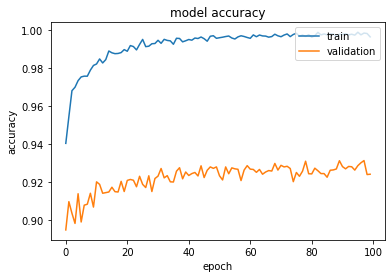

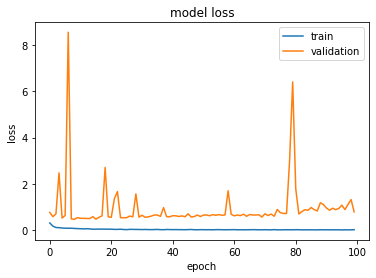

In [45]:
# plotting the accuracy and loss curves
# Now we can plot the loss curves to visualize the model performance
# list all data in history
print(history_classification.history.keys())

# summarize history for loss
plt.plot(history_classification.history['accuracy'])
plt.plot(history_classification.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history_classification.history['loss'])
plt.plot(history_classification.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Model evaluation on the test set

In [46]:
test_eval = full_model.evaluate(test_data, X_test_one_hot, verbose=1)

313/313 [==============================] - 13s 42ms/step - loss: 1.1059 - accuracy: 0.9169


In [47]:
# Let us see the test accuracy and loss
print('Test Accuracy', test_eval[0])
print('Test Loss', test_eval[1])

Test Accuracy 1.105850338935852
Test Loss 0.9168999791145325


### Prediction

In [49]:
predicted_classes = full_model.predict(test_data)
print(np.argmax(predicted_classes[1]))

2


In [50]:
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

In [51]:
print(predicted_classes[1])

2


In [52]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Correctly identified samples are:  9164


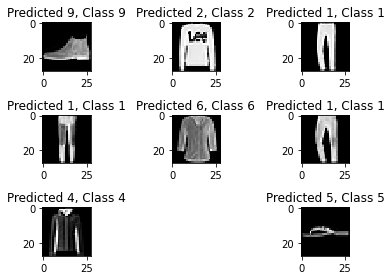

In [53]:
# finding the correct predicted labels
correct = np.where(predicted_classes == test_labels)[0]

print("Correctly identified samples are: ", len(correct))
for i,correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Incorrectly identified samples are:  836


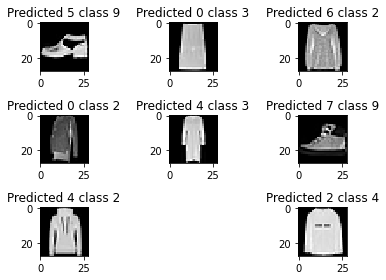

In [54]:
# finding the incorrect predictions
incorrect = np.where(predicted_classes != test_labels)[0]

print("Incorrectly identified samples are: ", len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {} class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

### Metrics

In [55]:
# Accuracy
print("Accuracy: ", accuracy_score(test_labels, predicted_classes))

Accuracy:  0.9164


In [56]:
# Classification report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86      1000
     Class 1       0.99      0.98      0.98      1000
     Class 2       0.90      0.83      0.86      1000
     Class 3       0.91      0.91      0.91      1000
     Class 4       0.86      0.89      0.87      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.74      0.79      0.77      1000
     Class 7       0.96      0.98      0.97      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [58]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

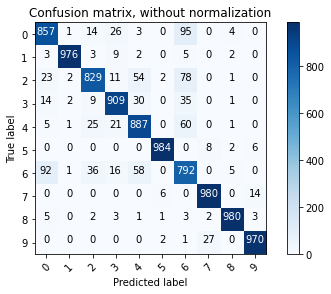

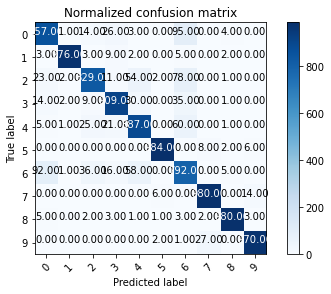

In [59]:
class_names = np.unique(test_labels)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Predicting the real time fashion images 

In [99]:
# Any real time fashion image belonging to these ten classes can be taken and predictions are maken,The below function allows to perform this task

(387, 500)


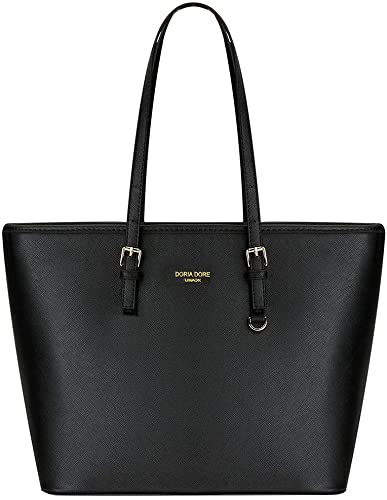

In [108]:
from PIL import Image
import os.path

filename = os.path.join('../projects/test_images/bags.jpg')
img = Image.open(filename)
print(img.size)
img

In [112]:
from keras.preprocessing.image import load_img, img_to_array 
from keras.models import load_model
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [145]:
full_model.save("s1.h5")

In [157]:
img = load_img('bags.jpg')
img = Image.open('bags.jpg').convert('L')
img = img.resize((28, 28))
img = img_to_array(img) 

img = img.reshape( -1,28, 28,1)

print(img.shape)
model = load_model('s1.h5')
# model.summary()
abc = model.predict(img)
# img

(1, 28, 28, 1)


In [154]:
abc

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [155]:
df2 = pd.DataFrame(abc,columns=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
# df2['image_name']=test

df2.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# VGG16 Model

In [1]:
import pandas as pd
import os, time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import applications
from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import LeakyReLU
import os
import warnings
warnings.filterwarnings('ignore')

In [174]:
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
(train_X,train_Y),(test_X,test_Y)=fashion_mnist.load_data()

In [58]:
import numpy as np

In [59]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

In [175]:
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

((60000, 28, 84), (10000, 28, 84))

In [176]:
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [177]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [63]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [64]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [65]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [66]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 3), (12000, 28, 28, 3), (48000, 10), (12000, 10))

In [70]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [71]:
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [72]:
base_model = VGG16(weights="imagenet",
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [90]:
train_X.shape

(48000, 48, 48, 3)

In [16]:
train_features = base_model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = base_model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = base_model.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 91s 122ms/step


In [92]:
import cv2

In [17]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [18]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [19]:
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="Adam",
    #optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    metrics=['accuracy'])

In [22]:
from keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
reduce_learning = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [23]:
history = model.fit(
    train_features_flat,
    train_label,
    epochs=100,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Epoch 1/100
1500/1500 [==============================] - 18s 11ms/step - loss: 0.8135 - accuracy: 0.7078 - val_loss: 2.3099 - val_accuracy: 0.4419 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.6871 - accuracy: 0.7492 - val_loss: 3.9627 - val_accuracy: 0.3233 - lr: 0.0010
Epoch 3/100
1497/1500 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.7598
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1500/1500 [==============================] - 16s 11ms/step - loss: 0.6476 - accuracy: 0.7598 - val_loss: 3.4617 - val_accuracy: 0.3195 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5618 - accuracy: 0.7945 - val_loss: 0.9825 - val_accuracy: 0.6823 - lr: 2.0000e-04
Epoch 5/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5430 - accuracy: 0.8000 - val_loss: 0.9462 - val_accuracy: 0.6913 - lr: 2.0000e-04
Epoch 6/100
1500/1500 [=

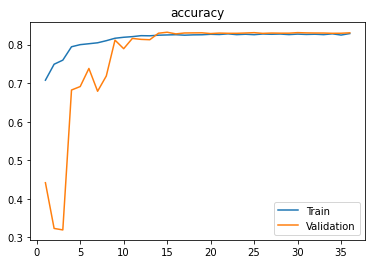

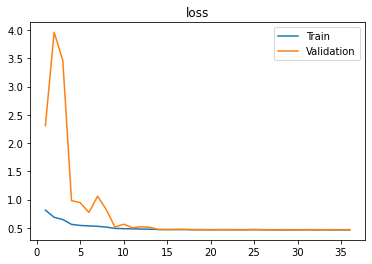

In [263]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('accuracy')
plt.plot(epochs, acc, label='Train')
plt.plot(epochs, val_acc,label='Validation')
plt.legend()

plt.figure()
plt.title('loss')
plt.plot(epochs, loss,label='Train')
plt.plot(epochs, val_loss,label='Validation')

plt.legend()
plt.show()

(387, 500)


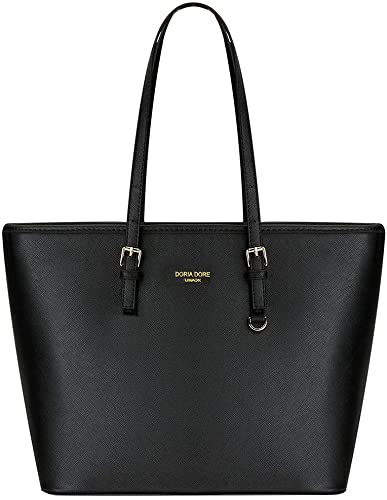

In [251]:
from PIL import Image
import os.path

filename = os.path.join('../projects/test_images/bags.jpg')
img = Image.open(filename)
print(img.size)
img

In [252]:
tes = np.asarray(img_to_array(array_to_img(img, scale=False).resize((48,48))))
tes = tes/255.
tes = tes.astype('float32')
test_image=preprocess_input(tes)
img = cv2.resize(test_image,(48,48))
img = img.reshape(1,48,48,3)
sample_features = base_model.predict((img))
sample_features.shape
test_features = np.reshape(sample_features, (1, 1*1*512))

In [261]:
test_image.shape

(48, 48, 3)

In [259]:
pred=model.predict(test_features)
np.argmax(pred)

8

In [260]:
df2 = pd.DataFrame(pred,columns=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
df2.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.000055,9.364586e-07,0.000003,9.273665e-08,9.598078e-07,0.000369,0.000002,0.000032,0.999537,3.145106e-11
